## Generate Data Sets
This file simulates a MASH structure and generates data sets for trainig a neural network.
The data sets are tied together in a dict and stored in a file using pickle. 

x: quantized output stream,  
y: input samples

In [2]:
import AnalogToDigital as ADC
import AnalogToDigital.deltaSigma as deltaSigma

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from scipy import signal
import _pickle as pickle
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configuration

In [11]:
# settings for dataset
dataset_name = 'eval_sine_wave_10k_32_3_2_2'
boundary_margin = 1000 # margin in samples, to prevent possible boundary effects
n_samples = 10000 # number of sample pairs (x, y)

OSR = 32 # oversampling rate, must be integer
order = 3 # how many mash blocks
order_mash_block = 2 # order of one mash block
n_lev = 2 # bit levels

### Sigma Delta Simulation

bandlimitted signal done
float64


/opt/anaconda/lib/python3.6/site-packages/deltasigma/_realizeNTF.py:149: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = -np.real(np.linalg.lstsq(T.T, L1.T)[0]).T


<IPython.core.display.Javascript object>


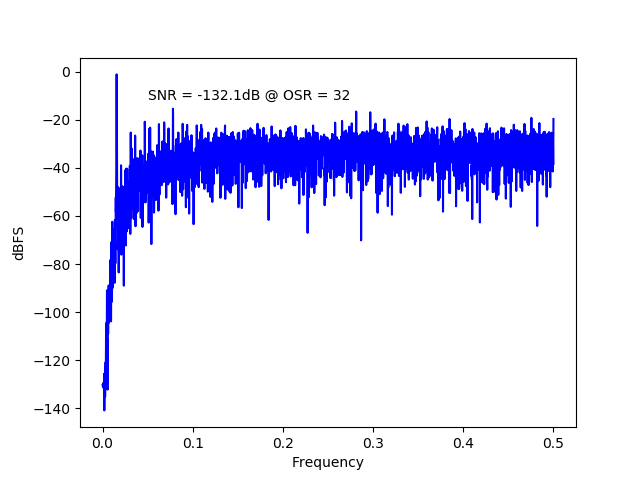

generating bits


<IPython.core.display.Javascript object>


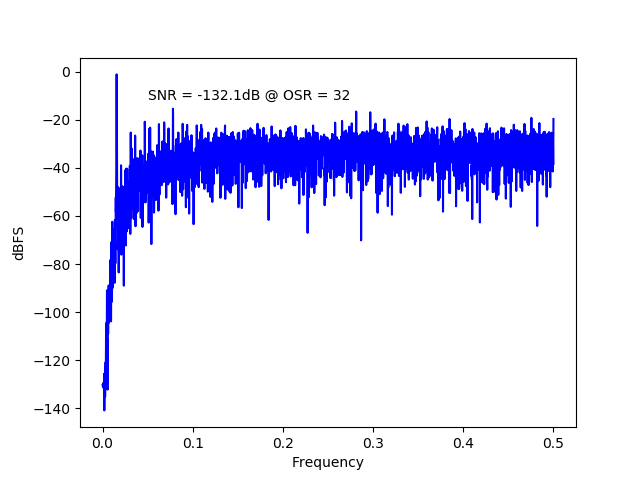

<IPython.core.display.Javascript object>


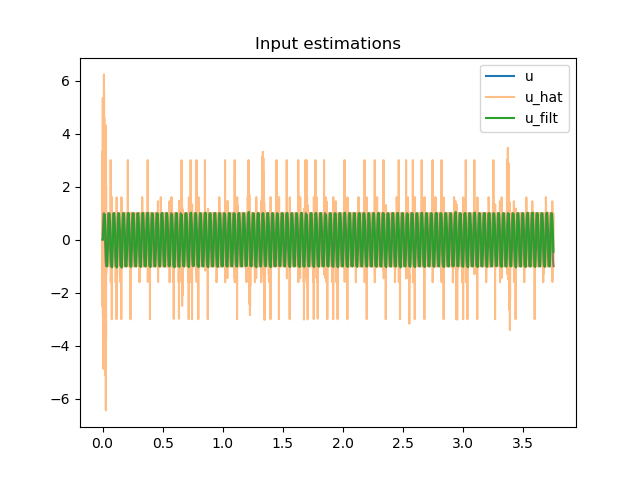

shape of input signal: (12000,)
shape of bit stream: (12000, 3)


In [16]:
"""
This runs the Sigma Delta Comparision
"""
size = n_samples + 2 * boundary_margin
# order = 3
# Ts = 80e-6
fp = 50.
Ts = 1. / 2. / fp / OSR
# print(Ts)
# OSR = 1. / Ts / 2. / fp
# print("OSR = %s" % OSR)
scaling = (2 ** order)

"""
Input signal
"""
dummy = np.zeros(order)
input = ADC.system.Sin(Ts, 1, 1./Ts / OSR / 4.0 , 0, steeringVector=dummy)

# np.random.seed()
# seed = np.random.randint(10000000)
# input = ADC.system.BandlimitedNoise(0.9, OSR, seed)
print("bandlimitted signal done")

"""
Simulation Variables
"""
t = np.linspace(0., Ts * (size - 1) , size)
u = input.scalarFunction(t)

print(u.dtype)



"""
Setup MASH
"""
ds = [deltaSigma.DeltaSigma(OSR, order_mash_block, nlev = n_lev) for x in range(order)]
mash = deltaSigma.MASH(OSR, ds)

"""
Simulate Spectrum
"""
mash.simSpectrum()

print("generating bits")
"""
Generate Data
"""
bits = mash.simulate(input, t)

# plt.figure()
# plt.plot(u)
# for ii in range(order):
#     plt.plot(bits[:,ii], label = "bit %i" % ii, alpha=0.6)
# plt.show()

# """
# Apply cancellation logic
# """
u_hat = mash.reconstruction(bits)
mash.simSpectrum()

u_filt = u_hat.copy()

n_filter_applied = 1
for ii in range(n_filter_applied):
    u_filt = mash.lowPassFilter(u_filt)

plt.figure()
plt.title("Input estimations")
plt.plot(t, u, label="u")
plt.plot(t, u_hat, label="u_hat", alpha=0.5)
plt.plot(t, u_filt, label="u_filt")

plt.legend()
plt.show()

print("shape of input signal: {}".format(u.shape))
print("shape of bit stream: {}".format(bits.shape))

### Compose data set

In [17]:
# bits
x = torch.from_numpy(np.int32(bits[boundary_margin : boundary_margin + n_samples])).type(torch.int8)

# u_hat
# x = torch.from_numpy(u_hat[boundary_margin : boundary_margin + n_samples])

# labels
y = torch.from_numpy(u[boundary_margin : boundary_margin + n_samples])

ds = {'x': x, 'y' : y}

# print(x.shape)
# print(y.shape)

# print(x[:10])
# print(y[:10])

# print(bits[:10])
# print(u[:10])


# ## old data set generation
# window_size = 100
# sample_offset = 50
# x = torch.zeros([n_samples- 2 * window_size, window_size, order], dtype=torch.int8)   # bit stream (signed int)
# y = torch.zeros([n_samples- 2 * window_size], dtype=torch.float)         # input sample (float / double)
# for ii in range(n_samples - 2 * window_size):
#     y[ii] = u[sample_offset + ii]
#     x[ii] = torch.from_numpy(np.int32(bits[ii : ii + window_size]))
# # x = torch.from_numpy(np.int32(bits[boundary_margin : boundary_margin + n_samples])).type(torch.int8)
# # y = torch.from_numpy(u[boundary_margin : boundary_margin + n_samples])
# ds = {'x': x, 'y' : y}

In [19]:
# dump dataset into a pickle file
print("dumping dataset to pickle file ..")

fname = 'Datasets/{}.pkl'.format(dataset_name)
if os.path.isfile(fname):
    print("ERROR: filename already exists!")
else:
    pickle.dump(ds, open(fname, 'wb', -1))
    print("done")

dumping dataset to pickle file ..
done


<IPython.core.display.Javascript object>


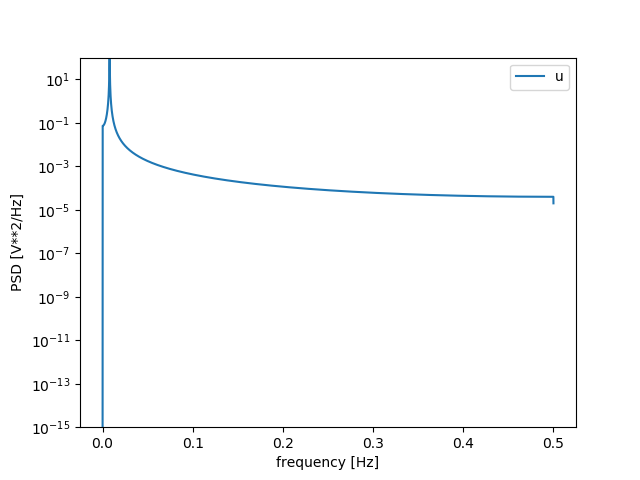

In [20]:
### debug plots
# plt.figure()
# plt.plot(y.numpy())                   


# plot psd of input signal
f, psd_u = signal.periodogram(u, 1)
f, psd_u_hat = signal.periodogram(u_hat, 1)
f, psd_u_filt = signal.periodogram(u_filt, 1)
# f, Pxx_den = signal.periodogram(u_hat, 1)
plt.figure()
plt.semilogy(f, psd_u, label='u')
# plt.semilogy(f, psd_u_hat, label='u_hat')
# plt.semilogy(f, psd_u_filt, label='u_filt')

plt.ylim([1e-15, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()

plt.show()